In [1]:
!pip install xgboost
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import gc


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/train_test_network.csv")

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [80]:
data.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')

In [5]:
data=data.drop_duplicates()

In [82]:
data.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


In [83]:
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [84]:
data['type'].value_counts()

,count
type,
normal,42040
scanning,20000
ddos,19993
injection,19964
password,19861
dos,18992
backdoor,18711
xss,15137
ransomware,14735


In [85]:
data["label"].value_counts()

,count
label,
1,148434
0,42040


In [6]:
encoders = {}

cat_cols = ['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query',
       'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version',
       'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject',
       'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri',
       'http_version', 'http_user_agent', 'http_orig_mime_types',
       'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice',
       'type']

for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

In [7]:
encoders["type"].classes_

array(['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal',
       'password', 'ransomware', 'scanning', 'xss'], dtype=object)

In [87]:
Y = data[['type','label']]
X= data.drop(["type","label"],axis=1)

In [88]:
X.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,0
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [89]:
mi_label = mutual_info_classif(X, Y["label"])
mi_type = mutual_info_classif(X, Y["type"])
mi_avg = (mi_label + mi_type ) / 2

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_label': mi_label,
    'MI_type': mi_type,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [90]:
X.head()

,src_ip_bytes,src_ip,dst_port,dst_ip_bytes,src_port,dst_ip,conn_state,duration,src_bytes,dst_bytes,src_pkts,dst_pkts,service,dns_query,proto,dns_rejected,dns_RA,dns_qtype,dns_RD,dns_AA
0,108064,26,49178,3832,4444,201,0,290.371539,101568,2592,108,31,0,1,1,0,0,0,0,0
1,52,16,8080,40,49180,210,1,0.000102,0,0,1,1,0,1,1,0,0,0,0,0
2,52,16,8080,40,49180,210,1,0.000148,0,0,1,1,0,1,1,0,0,0,0,0
3,48,16,8080,40,49180,210,1,0.000113,0,0,1,1,0,1,1,0,0,0,0,0
4,52,16,8080,40,49180,210,1,0.000130,0,0,1,1,0,1,1,0,0,0,0,0


In [91]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["label"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["type"])



importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)



combined_features = set(top_features) | set(top_features1)
X = X[list(combined_features)]

In [92]:
X.head()

,dst_pkts,src_ip,service,dns_RD,dst_bytes,src_pkts,src_ip_bytes,duration,conn_state,dst_port,src_port,src_bytes,dst_ip,dns_rejected,proto,dns_qtype,dst_ip_bytes,dns_RA
0,31,26,0,0,2592,108,108064,290.371539,0,49178,4444,101568,201,0,1,0,3832,0
1,1,16,0,0,0,1,52,0.000102,1,8080,49180,0,210,0,1,0,40,0
2,1,16,0,0,0,1,52,0.000148,1,8080,49180,0,210,0,1,0,40,0
3,1,16,0,0,0,1,48,0.000113,1,8080,49180,0,210,0,1,0,40,0
4,1,16,0,0,0,1,52,0.000130,1,8080,49180,0,210,0,1,0,40,0


In [93]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [95]:
y_all = y_train[['label', 'type']].reset_index(drop=True)

sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_label_resampled = sm.fit_resample(X_train, y_all['label'])

n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

type_original = y_all['type'].iloc[:n_original].tolist()

normal_encoded = 5

synthetic_types = [normal_encoded] * n_synthetic

type_final = type_original + synthetic_types
label_final = y_label_resampled.tolist()

y_train_resampled = pd.DataFrame({
    'type': type_final,
    'label': label_final
})

X_train = X_resampled
y_train = y_train_resampled

In [96]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_label = RandomForestClassifier(max_depth=max_depth)
        self.rfc_type = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_label.fit(X_train,y_train['label'])

        features_type = np.concatenate((X_train,np.array(y_train['label']).reshape(-1,1)),axis=1)
        self.rfc_type.fit(features_type,y_train['type'])


    def predict(self,X_test):
        predict_label = self.rfc_label.predict(X_test)
        y_proba=self.rfc_label.predict_proba(X_test)[:,1]
        test_type = np.concatenate((X_test,predict_label.reshape(-1,1)),axis=1)
        predict_type = self.rfc_type.predict(test_type)

        return pd.DataFrame({'label':predict_label,'type':predict_type,"y_proba":y_proba})

In [97]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    # Classification report as table
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    # Multi-class Precision-Recall curve
    if y_proba is not None:
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        plt.figure(figsize=(10, 7))
        for i, cls in enumerate(classes):
            if y_proba.ndim == 1 or y_proba.shape[1] == 1:
                raise ValueError("y_proba must be 2D array for multi-class PR curve")
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
            ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
            plt.plot(recall, precision, label=f"{cls} (AP={ap:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Multi-class Precision-Recall Curve - {title}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

**Random Forest**

In [98]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.992358  0.973002  0.982585   8408.0
1   0.992396  0.997878  0.995129  29687.0


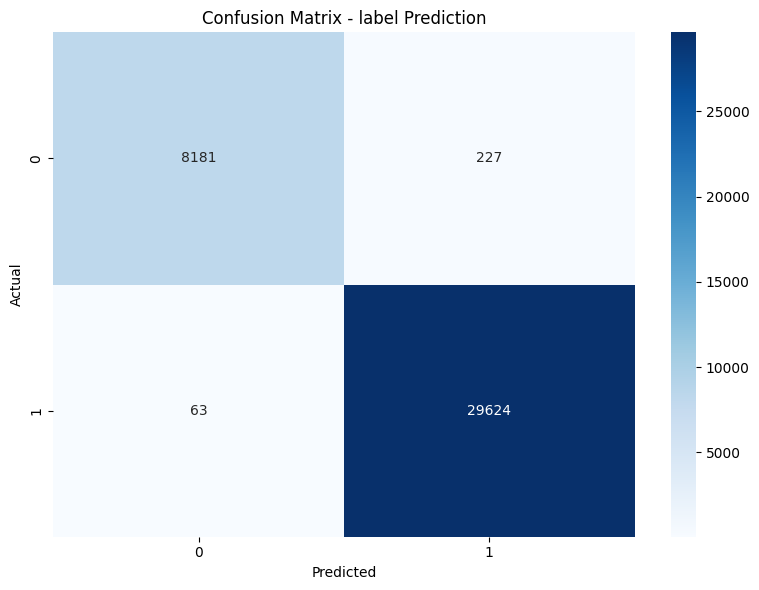


✅ Accuracy: 0.9924
✅ Weighted F1 Score: 0.9924
✅ Macro F1 Score: 0.9889
✅ Macro Precision: 0.9924
✅ Macro Recall: 0.9854
❌ Hamming Loss: 0.007613


In [99]:
display_metrics(y_test['label'], predictions_rfc['label'], "label Prediction")


--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.975513  0.990112  0.982759   3742.0
1   0.724443  0.901975  0.803520   3999.0
2   0.764070  0.911292  0.831212   3799.0
3   0.702262  0.894315  0.786737   3993.0
4   0.000000  0.000000  0.000000    208.0
5   0.992010  0.974548  0.983201   8408.0
6   0.946468  0.752266  0.838266   3972.0
7   0.985714  0.959959  0.972666   2947.0
8   0.929911  0.942000  0.935917   4000.0
9   0.981658  0.442022  0.609567   3027.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


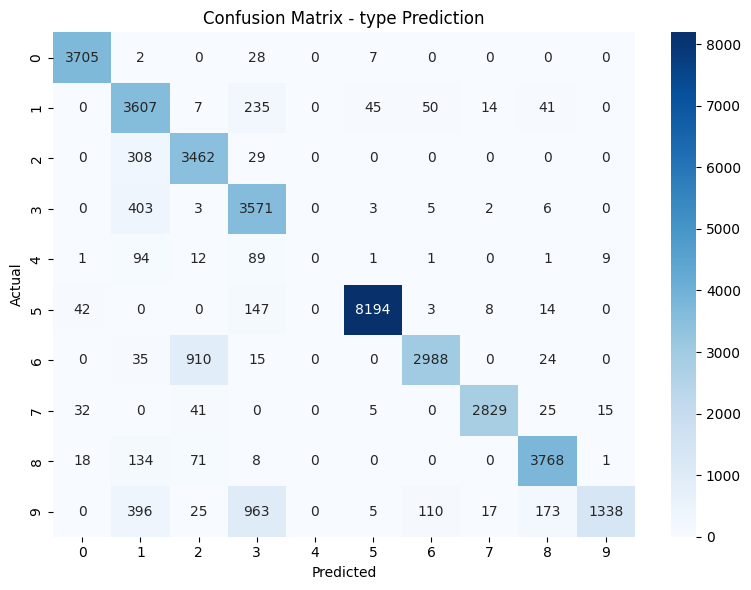


✅ Accuracy: 0.8784
✅ Weighted F1 Score: 0.8726
✅ Macro F1 Score: 0.7744
✅ Macro Precision: 0.8002
✅ Macro Recall: 0.7768
❌ Hamming Loss: 0.121617


In [100]:
display_metrics(y_test['type'], predictions_rfc['type'], "type Prediction")

XGB graddient boosting


In [101]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["label"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999762  0.999881  0.999822   8408.0
1   0.999966  0.999933  0.999949  29687.0


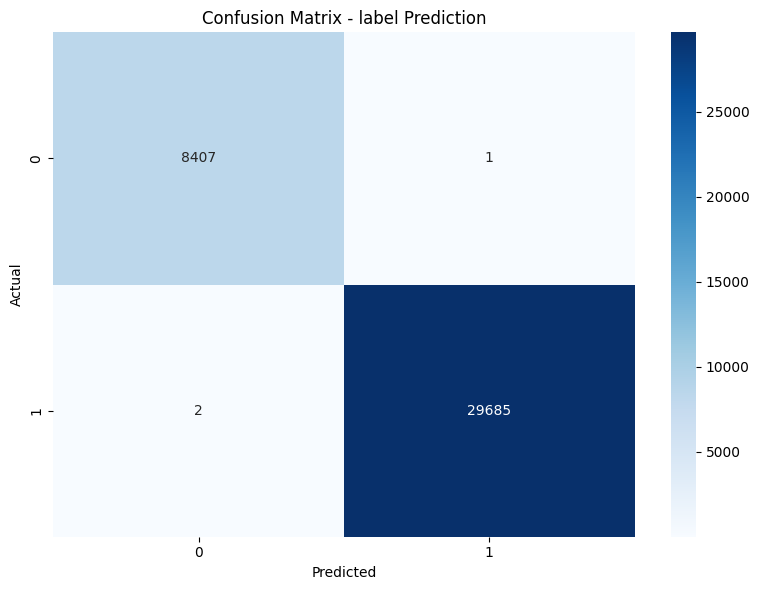


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9999
✅ Macro Precision: 0.9999
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000079


In [102]:
display_metrics(y_test['label'], y_pred_xgb, "label Prediction")


In [103]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["type"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.994741  0.993248  0.993994   3999.0
2   0.995252  0.993156  0.994203   3799.0
3   0.990243  0.991235  0.990738   3993.0
4   0.913043  0.908654  0.910843    208.0
5   0.999762  0.999762  0.999762   8408.0
6   0.995710  0.993454  0.994581   3972.0
7   0.999661  1.000000  0.999830   2947.0
8   0.991291  0.996000  0.993640   4000.0
9   1.000000  1.000000  1.000000   3027.0


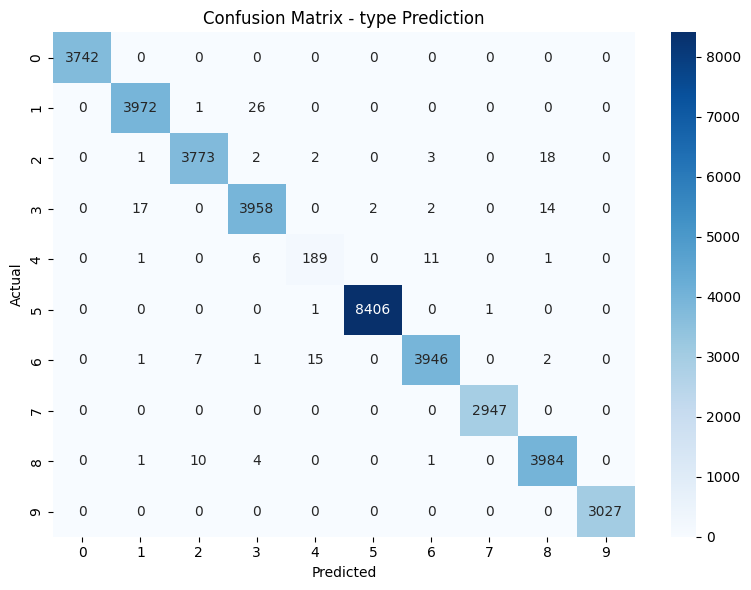


✅ Accuracy: 0.9960
✅ Weighted F1 Score: 0.9960
✅ Macro F1 Score: 0.9878
✅ Macro Precision: 0.9880
✅ Macro Recall: 0.9876
❌ Hamming Loss: 0.003964


In [104]:
display_metrics(y_test['type'], y_pred_xgb, "type Prediction")

Logistic Regression


In [105]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["label"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.971676  0.975143  0.973406   8408.0
1   0.992953  0.991949  0.992451  29687.0


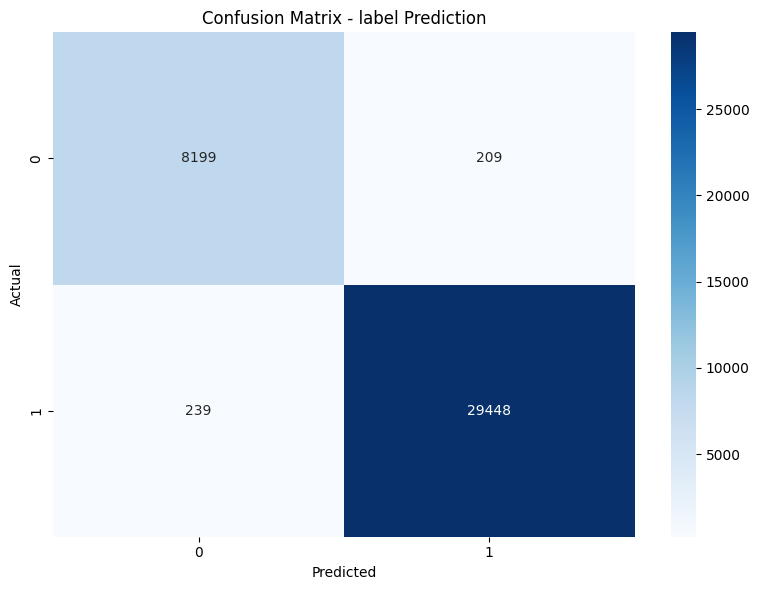


✅ Accuracy: 0.9882
✅ Weighted F1 Score: 0.9882
✅ Macro F1 Score: 0.9829
✅ Macro Precision: 0.9823
✅ Macro Recall: 0.9835
❌ Hamming Loss: 0.011760


In [106]:
display_metrics(y_test['label'], y_pred_logreg, "label Prediction")


In [107]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["type"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.931875  0.990647  0.960363   3742.0
1   0.793401  0.895974  0.841574   3999.0
2   0.938453  0.939195  0.938824   3799.0
3   0.716008  0.639619  0.675661   3993.0
4   0.736842  0.134615  0.227642    208.0
5   0.963437  0.984063  0.973641   8408.0
6   0.704038  0.746224  0.724517   3972.0
7   0.896209  0.826264  0.859816   2947.0
8   0.953902  0.858750  0.903828   4000.0
9   0.800845  0.814338  0.807535   3027.0


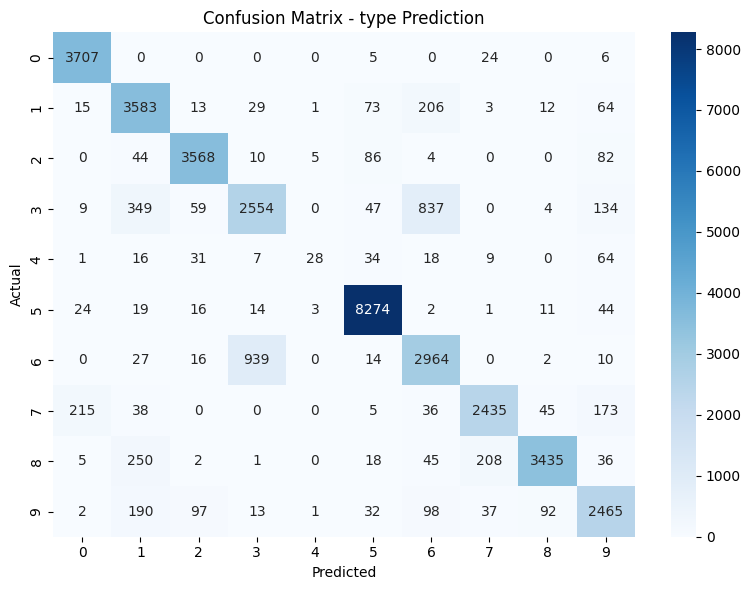


✅ Accuracy: 0.8666
✅ Weighted F1 Score: 0.8644
✅ Macro F1 Score: 0.7913
✅ Macro Precision: 0.8435
✅ Macro Recall: 0.7830
❌ Hamming Loss: 0.133403


In [108]:
display_metrics(y_test['type'], y_pred_logreg, "type Prediction")

Stacked Model

In [109]:
class StackedEnsemble:
    def __init__(self, n_folds=5, random_state=42):
        self.n_folds = n_folds
        self.random_state = random_state
        self.base_learners = [
            XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
            RandomForestClassifier(n_estimators=200, random_state=random_state)
        ]
        self.meta_learner = LogisticRegression(multi_class='multinomial', max_iter=1000)
        self.classes_ = None

    def fit(self, X, y):
        # Convert DataFrame/Series to NumPy arrays if needed
        if hasattr(X, "values"):
            X = X.values
        if hasattr(y, "values"):
            y = y.values

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_samples = X.shape[0]
        base_preds = np.zeros((n_samples, n_classes * len(self.base_learners)))

        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for i, model in enumerate(self.base_learners):
            oof_preds = np.zeros((n_samples, n_classes))
            for train_idx, val_idx in skf.split(X, y):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold = y[train_idx]
                model.fit(X_train_fold, y_train_fold)
                oof_preds[val_idx, :] = model.predict_proba(X_val_fold)
            base_preds[:, i*n_classes:(i+1)*n_classes] = oof_preds
            model.fit(X, y)

        self.meta_learner.fit(base_preds, y)

    def predict_proba(self, X):
        if hasattr(X, "values"):
            X = X.values
        n_classes = len(self.classes_)
        base_preds = np.zeros((X.shape[0], n_classes * len(self.base_learners)))
        for i, model in enumerate(self.base_learners):
            base_preds[:, i*n_classes:(i+1)*n_classes] = model.predict_proba(X)
        return self.meta_learner.predict_proba(base_preds)

    def predict(self, X):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        return preds


In [110]:
stacked=StackedEnsemble(n_folds=5)


stacked.fit(X_train, y_train["label"])



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:05:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:05:17] WARNING: /w


--- label ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999762  0.999881  0.999822   8408.0
1   0.999966  0.999933  0.999949  29687.0


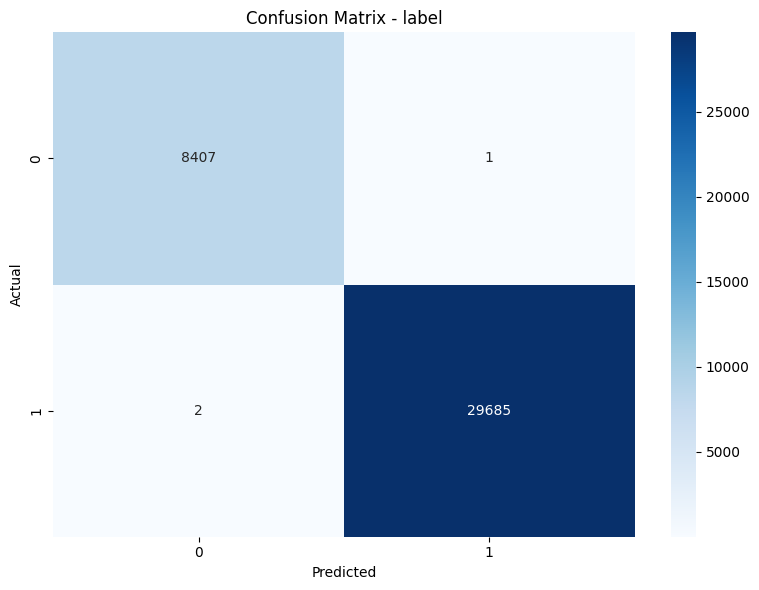


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9999
✅ Macro Precision: 0.9999
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000079


In [112]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)
display_metrics(y_test["label"], y_pred_attack,"label")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:59:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:59:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:00:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:01:04] WARNING: /w


--- type ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.994989  0.992998  0.993992   3999.0
2   0.994989  0.993156  0.994072   3799.0
3   0.989019  0.992487  0.990750   3993.0
4   0.926108  0.903846  0.914842    208.0
5   0.999762  0.999881  0.999822   8408.0
6   0.996217  0.994461  0.995338   3972.0
7   1.000000  1.000000  1.000000   2947.0
8   0.992271  0.995000  0.993634   4000.0
9   0.999670  1.000000  0.999835   3027.0


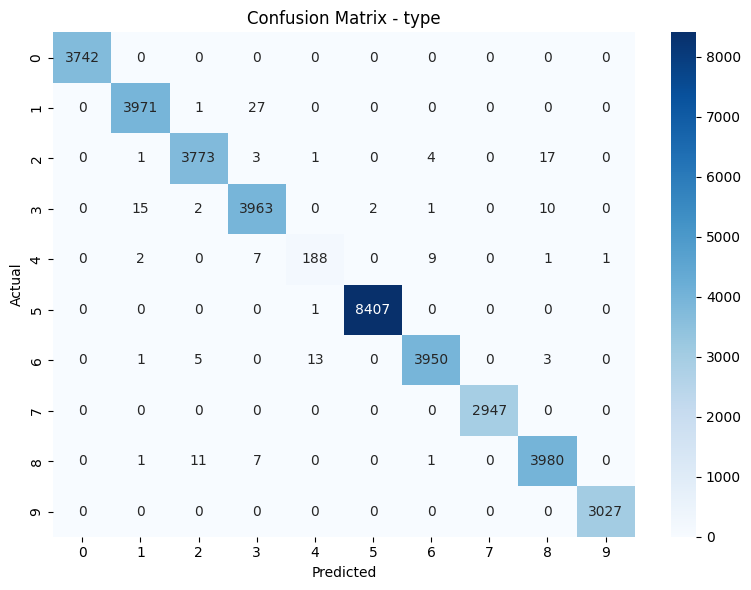


✅ Accuracy: 0.9961
✅ Weighted F1 Score: 0.9961
✅ Macro F1 Score: 0.9882
✅ Macro Precision: 0.9893
✅ Macro Recall: 0.9872
❌ Hamming Loss: 0.003859


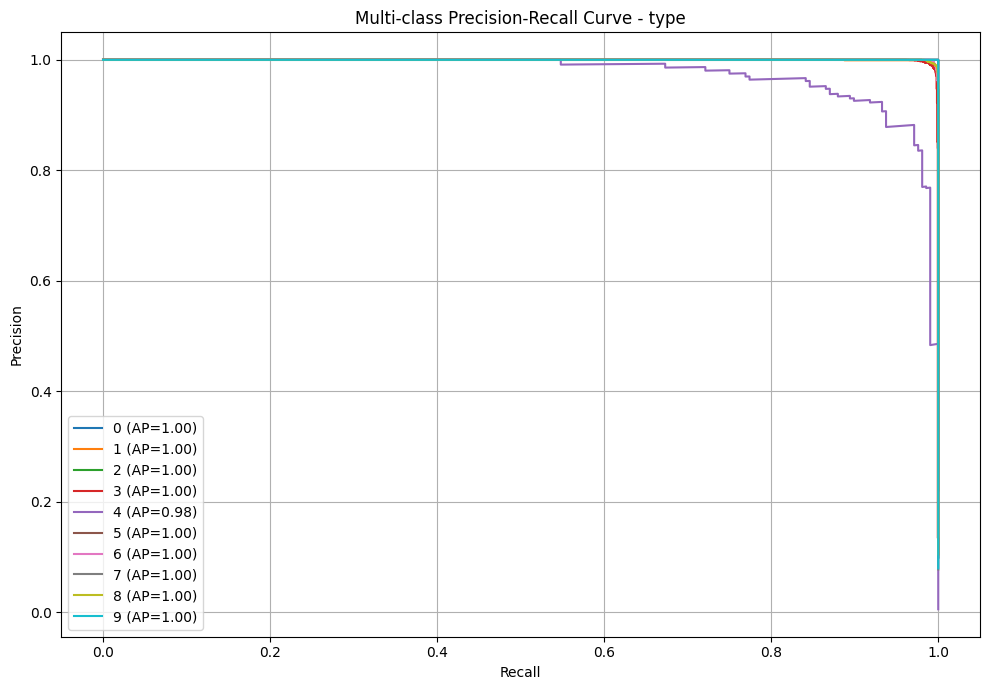

In [113]:
stacked=StackedEnsemble(n_folds=5)

X_cat = np.concatenate([X_train, y_train["label"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["type"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)

y_pred_category = stacked.predict(X_cat_test)
y_proba = stacked.predict_proba(X_cat_test)
display_metrics(y_test["type"], y_pred_category,title="type",y_proba=y_proba)

